# TacTip image mapping with UNet models

In [1]:
%matplotlib inline

import pandas as pd

In [2]:
# !pip install -Uqq fastai

In [3]:
from fastai.vision.all import *

## Download and uncompress data

In [4]:
data_url = "https://github.com/jlloyd237/datasets/raw/master/tactip/surface_3d_sliding/data_09111613_density.tgz"
data_path = untar_data(data_url)
data_path

Path('C:/Users/John/.fastai/data/data_09111613_density')

## Inspect data before using it to build a model

Let's see what we've got ...

In [5]:
data_path.ls()

(#3) [Path('C:/Users/John/.fastai/data/data_09111613_density/density_images'),Path('C:/Users/John/.fastai/data/data_09111613_density/images.csv'),Path('C:/Users/John/.fastai/data/data_09111613_density/pp_images')]

We've got a `pp_images` directory, a `density_images` directory, and an`images.csv` file. Let's explore ...

In [6]:
pp_image_files = get_image_files(data_path/'pp_images')
len(pp_image_files)

2000

There are 2000 files in the `pp_image` directory. Let's take a closer look at one of these files ...

In [7]:
image_id = 999
pp_image_files[image_id]

Path('C:/Users/John/.fastai/data/data_09111613_density/pp_images/image_1899.jpg')

In [8]:
pp_image = PILImage.create(pp_image_files[image_id])
pp_image.shape

(224, 224)

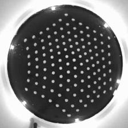

In [9]:
pp_image.to_thumb(128)

So, it's a 224 x 224 grayscale TacTip sensor image. Now let's take a look at the corresponding density images ...

In [10]:
density_image_files = get_image_files(data_path/'density_images')
len(density_image_files)

2000

In [11]:
density_image_files[image_id]

Path('C:/Users/John/.fastai/data/data_09111613_density/density_images/image_1899.jpg')

In [12]:
density_image = PILImage.create(density_image_files[image_id])
density_image.shape

(224, 224)

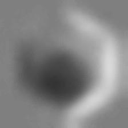

In [13]:
density_image.to_thumb(128)

We can see that this image corresponds to the raw sensor image above, with a lower-density central contact region and a higher-density region on the right, which is due to post-contact shear. Although, we don't need it here, let's take a quick look at the CSV image label file ...

In [14]:
df = pd.read_csv(data_path/"images.csv")
df.head()

image  obj_id  pose_id  pose_1  pose_2    pose_3     pose_4   
0  image_1.jpg       1        1     0.0     0.0  1.001410  -2.596750  \
1  image_2.jpg       1        2     0.0     0.0  1.003325   2.814944   
2  image_3.jpg       1        3     0.0     0.0  1.006138  19.548570   
3  image_4.jpg       1        4     0.0     0.0  1.006464  -7.151401   
4  image_5.jpg       1        5     0.0     0.0  1.008179   2.121820   

      pose_5  pose_6  offset_1  offset_2  offset_3  offset_4  offset_5   
0  12.634067     0.0  2.175631 -3.495094       0.0      -5.0  3.392090  \
1  -8.789049     0.0 -3.688051  3.854257       0.0      -5.0  2.210144   
2  12.199003     0.0 -2.066486 -2.521512       0.0      -5.0 -3.798709   
3  19.890319     0.0 -1.338869 -4.803968       0.0      -5.0 -3.122219   
4 -19.532084     0.0  0.328500 -2.007408       0.0      -5.0  3.014893   

   offset_6  
0 -3.963681  
1  3.434650  
2  2.090196  
3 -4.181790  
4 -1.101835

# Forward model (real2sim) based on pre-trained ResNet34 UNet

## Set up data mapping and dataloaders

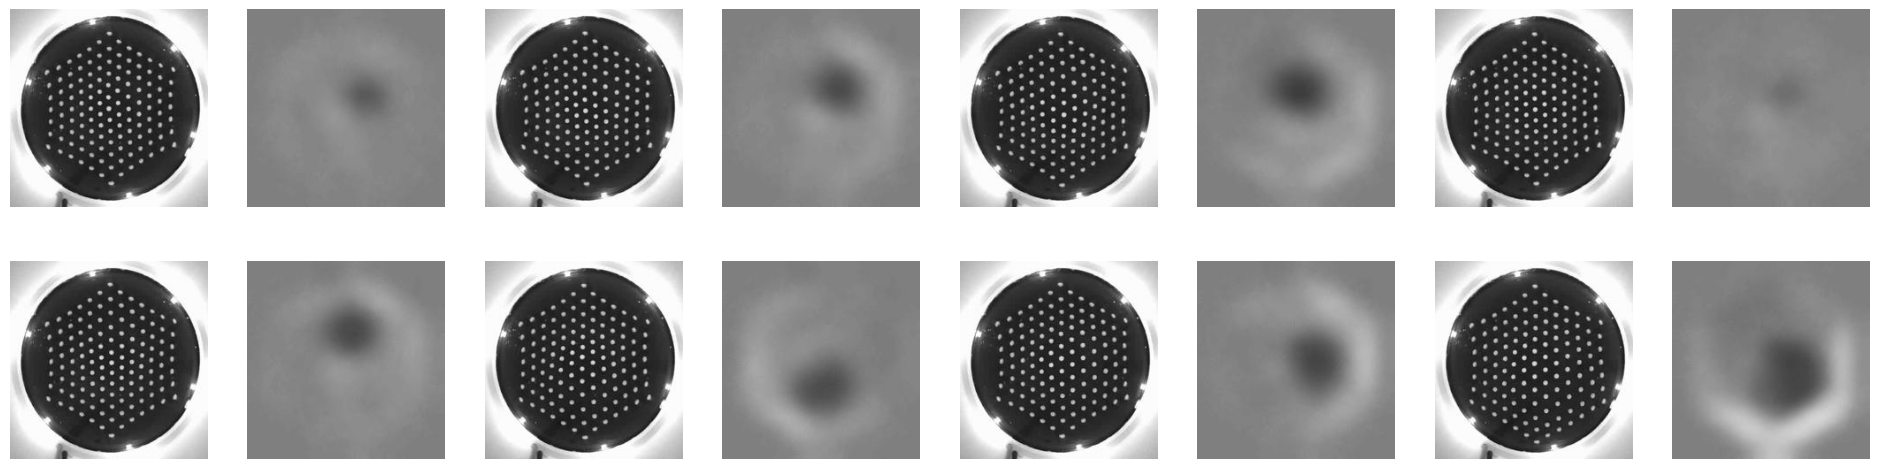

In [15]:
db = DataBlock(blocks=(ImageBlock, ImageBlock),
               get_items=get_image_files,
               splitter=RandomSplitter(valid_pct=0.2),
               get_y=lambda x: data_path/"density_images"/x.name,)
dls = db.dataloaders(data_path/"pp_images", bs=8)
dls.c = 3
dls.show_batch()

## Set up model, loss function, optimizer, etc.

In [16]:
learn = unet_learner(dls, arch=models.resnet34, pretrained=True, loss_func=MSELossFlat(), blur=True, 
                     self_attention=True, norm_type=NormType.Weight, act_cls=Mish, opt_func=ranger)
learn.summary()

C:\Users\John\Anaconda3\envs\tf2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\John\Anaconda3\envs\tf2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DynamicUnet (Input shape: 8 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 56 x 56    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

By default, most of the parameters in the encoder part of the UNet will be frozen, and so we'll start by fine-tuning the decoder. But first, let's find a good (maximum) learning rate ...

SuggestedLRs(valley=0.00015848931798245758)

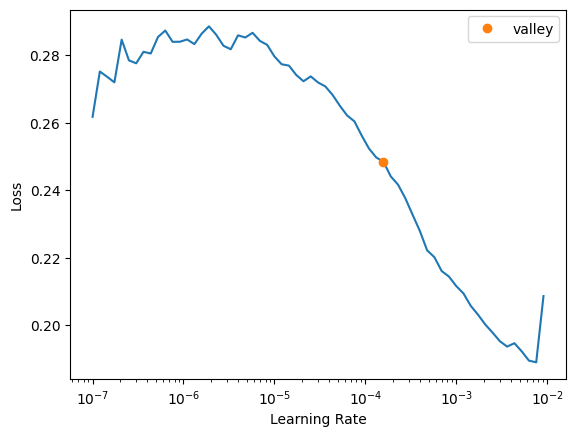

In [17]:
learn.lr_find()

We'll choose a LR that's approximately an order of magnitude smaller than the LR associated with the minimum loss (one of many rules-of-thumb) and train for 5 epochs. `fit_flat_cos` uses a type of "one-cycle" LR schedule, which is tailored to the Ranger optimizer (the Ranger optimizer seems to work a bit better than Adam on this task). We'll also use discriminative learning rates, where the last parameter group in the model is updated using a learning rate of lr, while the remaining groups are updated using lr/10 (indicated by using `slice(lr)` rather than just `lr` as the learning rate argument) ...

In [18]:
lr = 3e-4

In [19]:
learn.fit_flat_cos(5, slice(lr))

Let's save the model and take a look at how it's doing ...

In [20]:
learn.save("unet-pre-stage-1")
learn.load("unet-pre-stage-1")

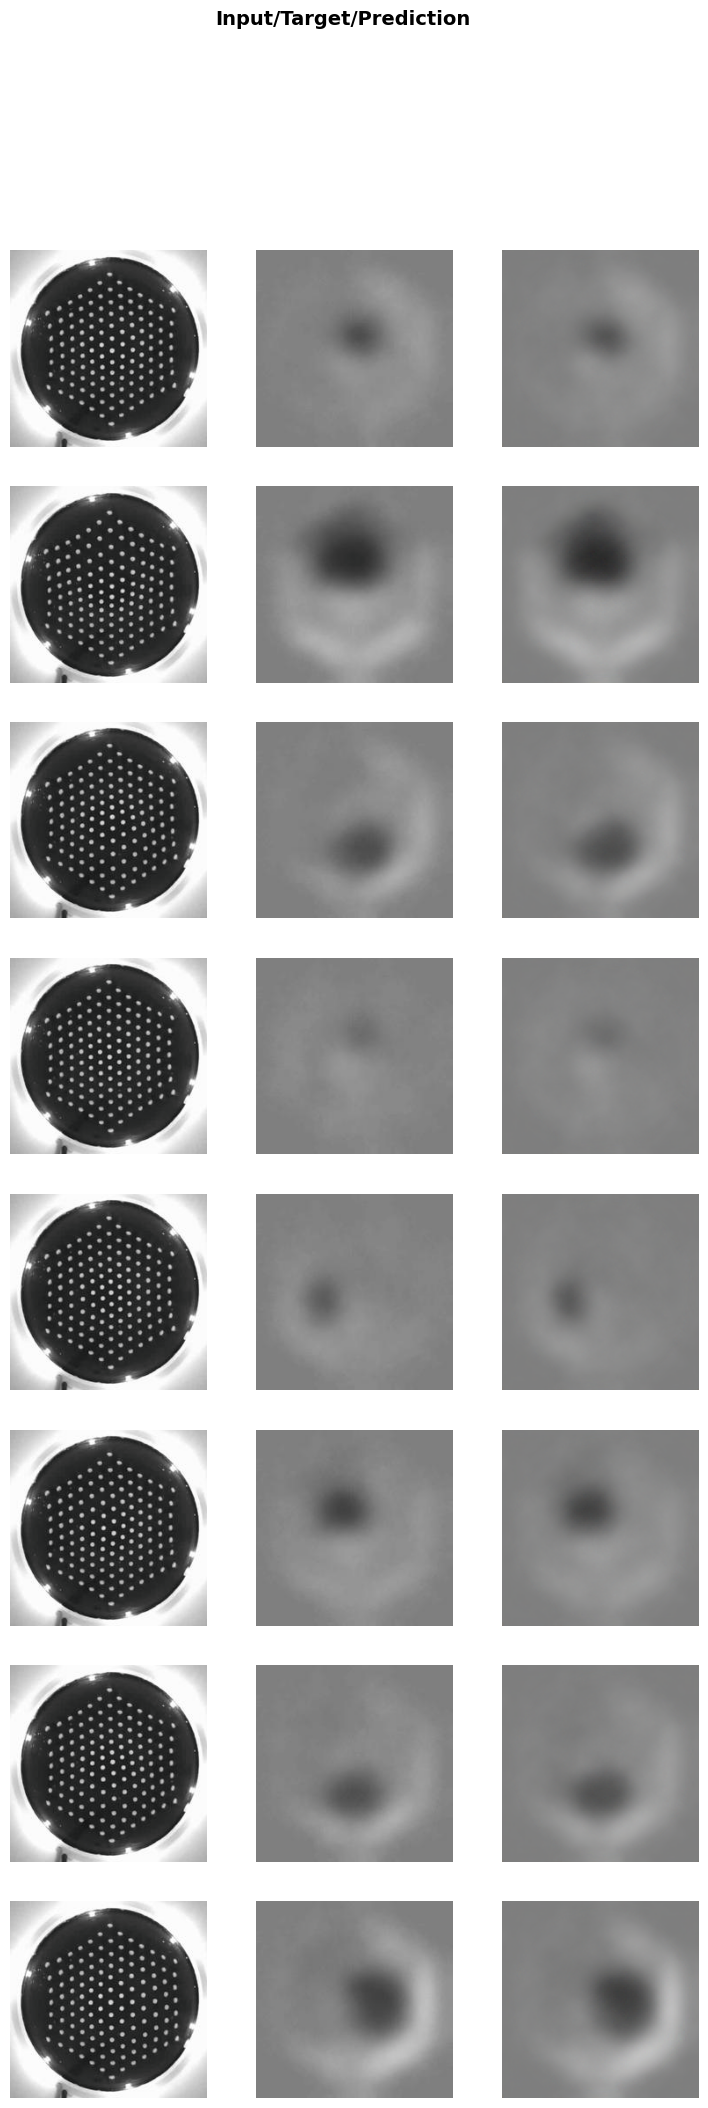

In [21]:
learn.show_results()

Not too bad! Now let's unfreeze the parameters in the encoder part of the UNet and use a set of smaller discriminative learning rates to perform end-to-end fine tuning for a further 10 epochs ...

In [22]:
learn.unfreeze()

In [23]:
lrs = slice(lr/400, lr/4)

In [24]:
lr, lrs

(0.0003, slice(7.499999999999999e-07, 7.5e-05, None))

In [25]:
learn.fit_flat_cos(10, lrs)

In [26]:
learn.save("unet-pre-stage-2")
learn.load("unet-pre-stage-2")

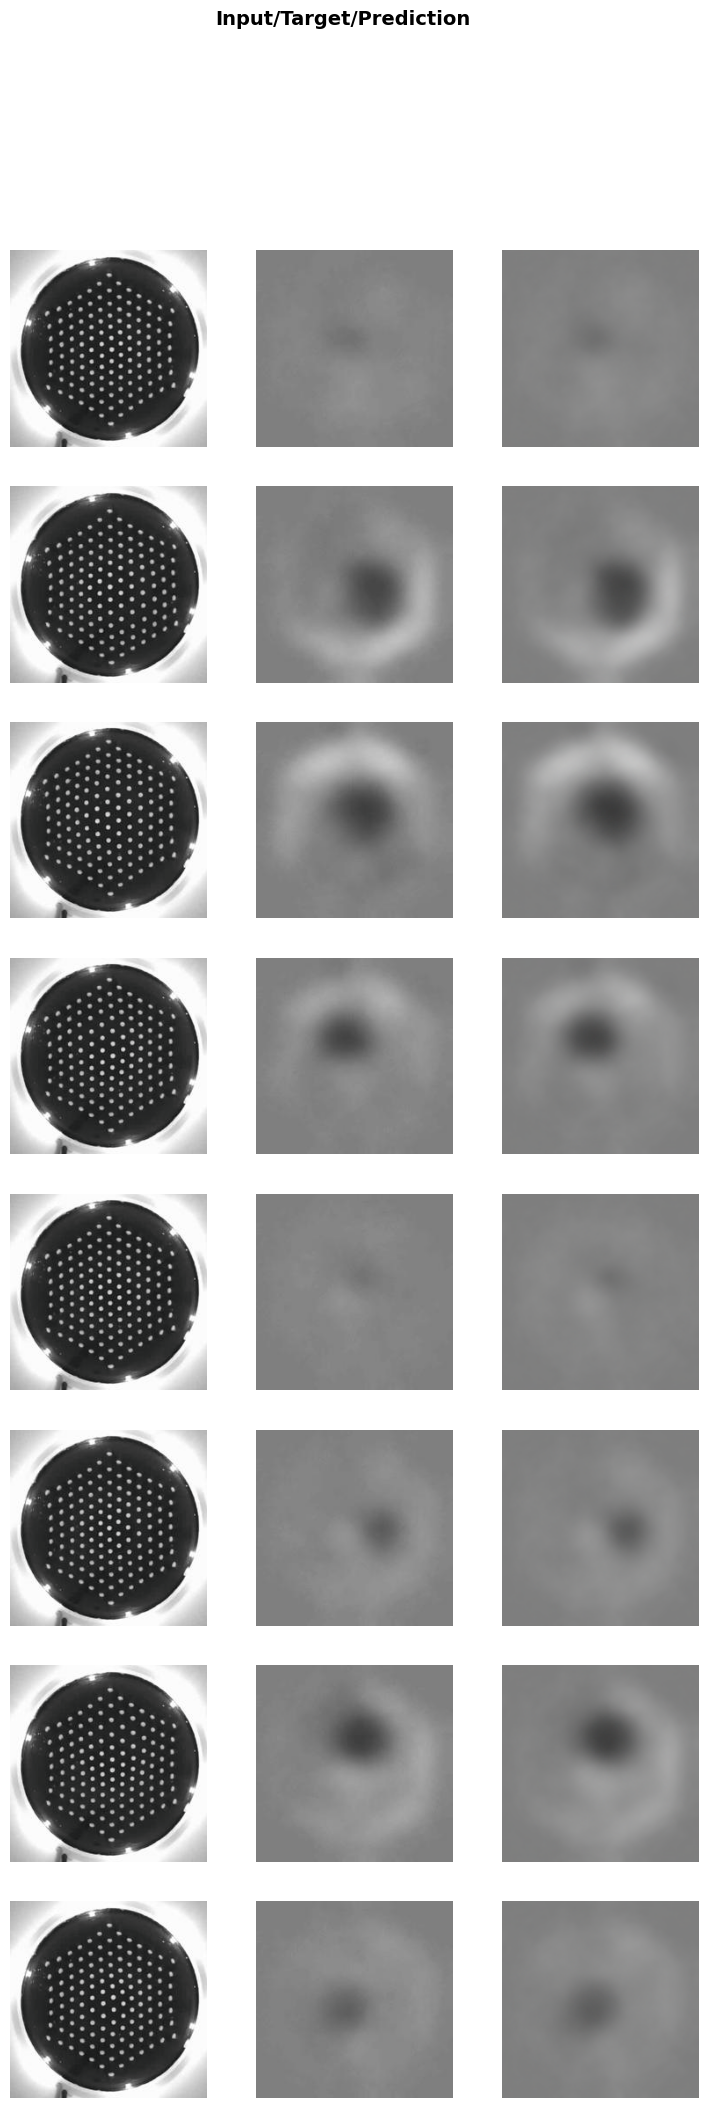

In [27]:
learn.show_results()

# Inverse model (sim2real) based on pre-trained ResNet34 UNet

Developing an inverse (sim2real) model follows a similar approach to developing a forward model, but the input/output data is reversed. However, it does appear to be a somewhat harder problem than learning a forward model, and consequently takes longer to train.

## Set up data mapping and dataloaders

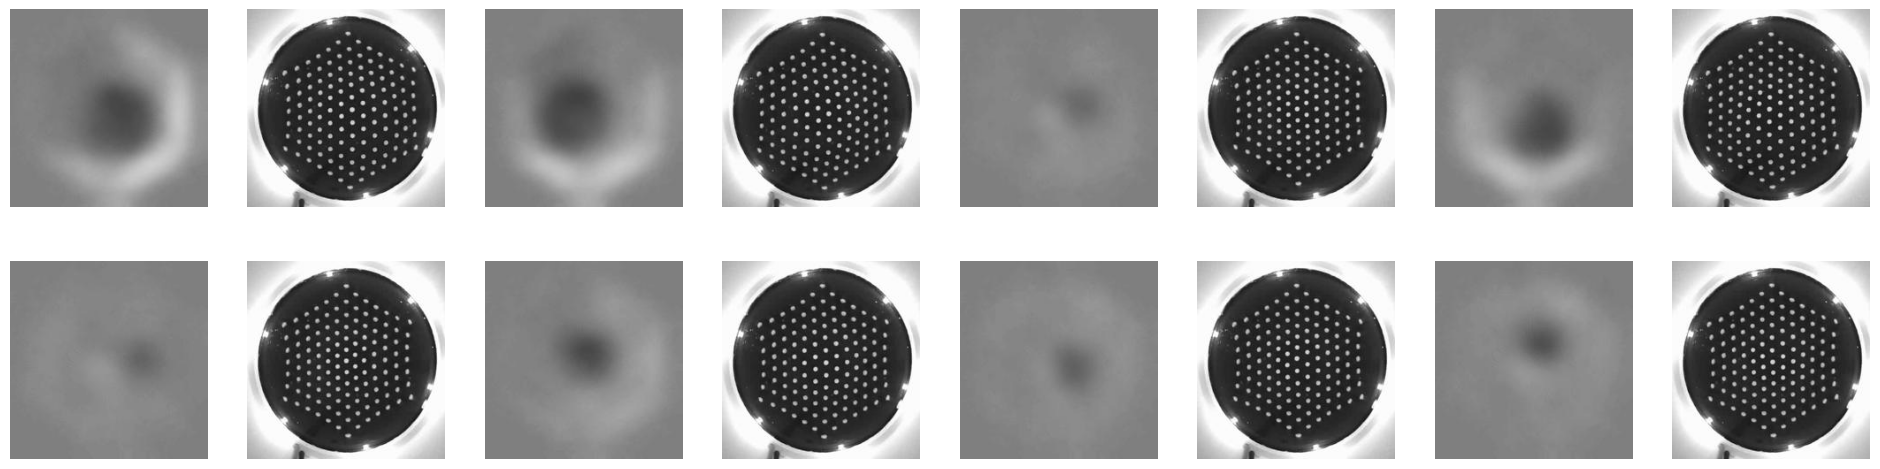

In [28]:
db = DataBlock(blocks=(ImageBlock(), ImageBlock()),
               get_items=get_image_files,
               splitter=RandomSplitter(valid_pct=0.2),
               get_y=lambda x: data_path/"pp_images"/x.name,)
dls = db.dataloaders(data_path/"density_images", bs=8)
dls.c = 3
dls.show_batch()

## Set up model, loss function, optimizer, etc.

In [29]:
learn = None
torch.cuda.empty_cache()

In [30]:
learn = unet_learner(dls, arch=models.resnet34, pretrained=True, loss_func=MSELossFlat(), blur=True, 
                     self_attention=True, norm_type=NormType.Weight, act_cls=Mish, opt_func=ranger)
learn.summary()

DynamicUnet (Input shape: 8 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 56 x 56    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

## Initial fine-tuning (decoder)

SuggestedLRs(valley=0.00013182566908653826)

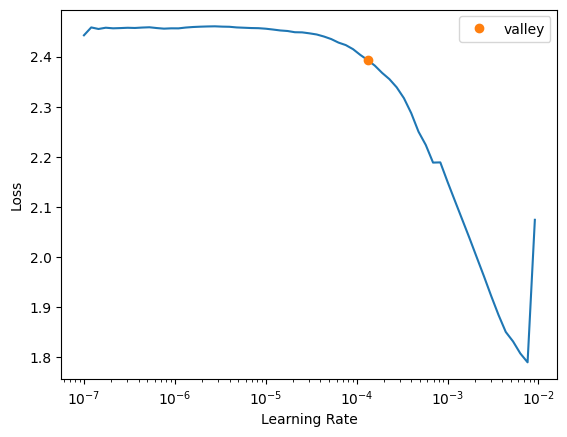

In [31]:
learn.lr_find()

In [32]:
lr = 7e-4

In [33]:
learn.fit_flat_cos(10, slice(lr))

In [34]:
learn.save("unet-pre-inv-stage-1")
learn.load("unet-pre-inv-stage-1")

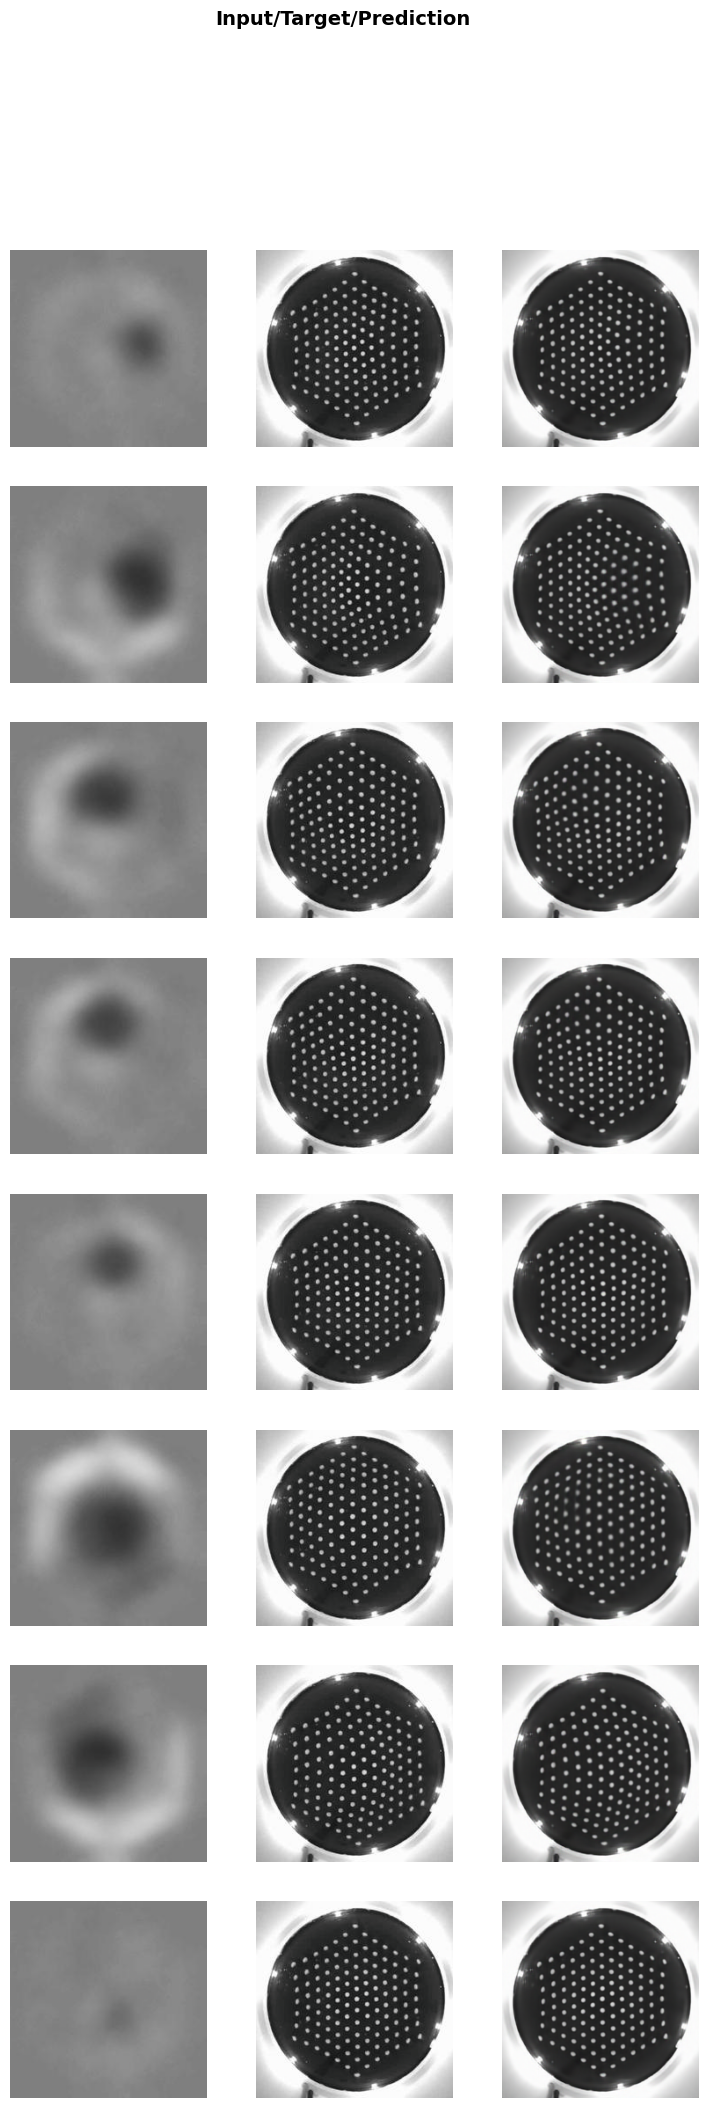

In [35]:
learn.show_results()

## End-to-end fine-tuning (decoder + encoder)

In [36]:
learn.unfreeze()

In [37]:
lrs = slice(lr/400, lr/4)

In [38]:
lr, lrs

(0.0007, slice(1.75e-06, 0.000175, None))

In [39]:
learn.fit_flat_cos(10, lrs)

In [40]:
learn.save("unet-pre-inv-stage-2")
learn.load("unet-pre-inv-stage-2")

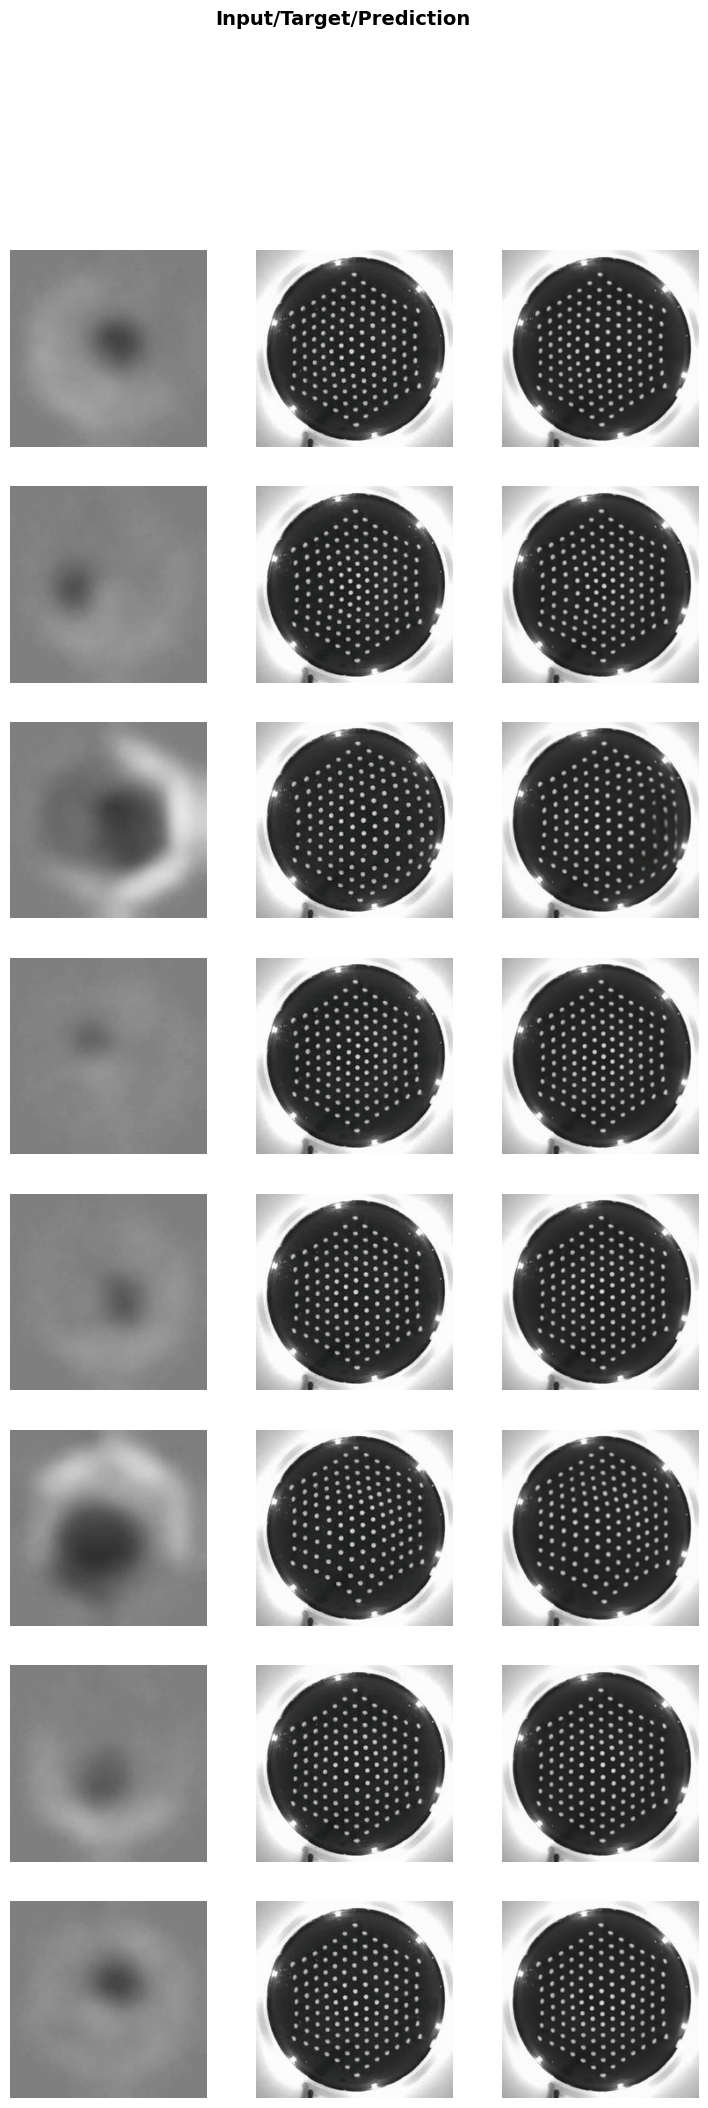

In [41]:
learn.show_results()

## More fine-tuning ...

In [42]:
lrs = slice(lr/1600, lr/16)

In [43]:
lr, lrs

(0.0007, slice(4.375e-07, 4.375e-05, None))

In [44]:
learn.fit_flat_cos(10, lrs)

In [45]:
learn.save("unet-pre-inv-stage-3")
learn.load("unet-pre-inv-stage-3")

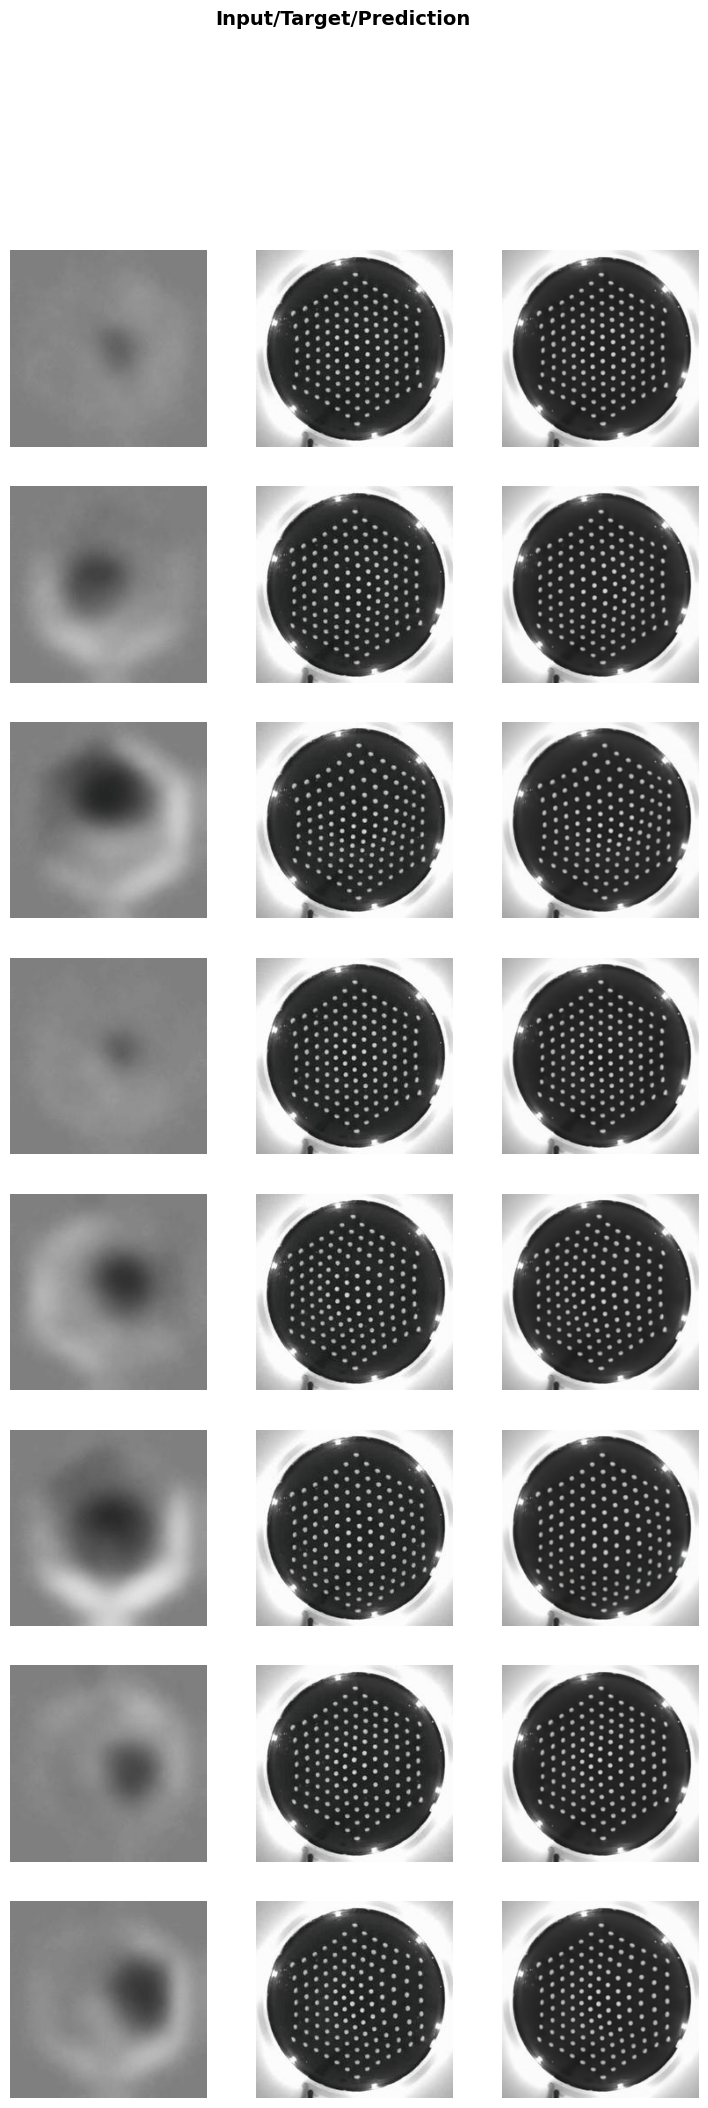

In [46]:
learn.show_results()